In [ ]:
! rm -rf UTKFace/

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Unzip data

In [ ]:
! tar -xvf UTKFace.tar.gz
! unzip irregular_mask.zip

Streaming output truncated to the last 5000 lines.
  inflating: irregular_mask/disocclusion_img_mask/50119.png  
  inflating: irregular_mask/disocclusion_img_mask/50120.png  
  inflating: irregular_mask/disocclusion_img_mask/50121.png  
  inflating: irregular_mask/disocclusion_img_mask/50122.png  
  inflating: irregular_mask/disocclusion_img_mask/50123.png  
  inflating: irregular_mask/disocclusion_img_mask/50124.png  
  inflating: irregular_mask/disocclusion_img_mask/50125.png  
  inflating: irregular_mask/disocclusion_img_mask/50126.png  
  inflating: irregular_mask/disocclusion_img_mask/50127.png  
  inflating: irregular_mask/disocclusion_img_mask/50128.png  
  inflating: irregular_mask/disocclusion_img_mask/50129.png  
  inflating: irregular_mask/disocclusion_img_mask/50130.png  
  inflating: irregular_mask/disocclusion_img_mask/50131.png  
  inflating: irregular_mask/disocclusion_img_mask/50132.png  
  inflating: irregular_mask/disocclusion_img_mask/50133.png  
  inflating: irregu

### Imports

In [ ]:
import os
from PIL import Image, ImageDraw, ImageFilter
import pandas as pd
import numpy as np
import torch
from torch import nn, tensor, from_numpy
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch
import random
import torch.nn.functional as F
import cv2
from matplotlib.pyplot import imshow
import math

### Common util functions

In [ ]:
def image2tensor(img):
  return from_numpy(np.array(img).transpose((2, 0, 1))).float()

def tensor2image(tnsr):
    return Image.fromarray(np.uint8(tnsr.numpy().transpose((1, 2, 0))))

def next_power_of_2(x):
    return 1 if x == 0 else 2**math.ceil(math.log2(x))

### UTK Face and Mask dataset grabber

In [ ]:
class UtkFaceSet(Dataset):
    def __init__(self, root_dir, mask_dir, mask_thresh=.6):
        self.root = root_dir
        self.mask_dir = mask_dir
        self.mask_file_names = [name for name in os.listdir(mask_dir) if os.path.isfile(mask_dir+name)]
        self.file_names = [name for name in os.listdir(root_dir) if os.path.isfile(root_dir+name)]
        self.length = len(self.file_names)
        self.thresh = mask_thresh*255
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # get the images
        img_name = os.path.join(self.root + self.file_names[idx])
        img = Image.open(img_name)
        img = img.resize((next_power_of_2(img.size[0]), next_power_of_2(img.size[1])))

        # get the mask
        mask_ind = random.randint(0, len(self.mask_file_names)-1)
        mask_img_path = os.path.join(self.mask_dir + self.mask_file_names[mask_ind])

        # apply random transforms to the mask
        # rotation, dialation, and scaling/cropping
        
        # binarize the mask
        mask_img = cv2.imread(mask_img_path)
        ret,mask_img = cv2.threshold(mask_img,self.thresh,255,cv2.THRESH_BINARY)

        # rotate the mask
        r = [cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_COUNTERCLOCKWISE]
        mask_img = cv2.rotate(mask_img, r[random.randint(0, len(r)-1)])

        # dilate the holes in the mask
        filter_size = random.randint(3, 7)
        ker = np.ones((filter_size, filter_size))
        img_erosion = cv2.erode(mask_img, ker, iterations=1) 

        # scale
        mask_img = cv2.resize(mask_img, (random.randint(int(mask_img.shape[0]*.8), int(mask_img.shape[0]*2)),
                                         random.randint(int(mask_img.shape[1]*.8), int(mask_img.shape[1]*2))))
        x1 = random.randint(int(mask_img.shape[0]*.2), int(mask_img.shape[0]*.5))
        x2 = random.randint(int(mask_img.shape[0]*.6), int(mask_img.shape[0]))
        y1 = random.randint(int(mask_img.shape[1]*.2), int(mask_img.shape[1]*.5))
        y2 = random.randint(int(mask_img.shape[1]*.6), int(mask_img.shape[1]))
        mask_img = mask_img[x1:x2, y1:y2]

        try:
          mask_img = cv2.resize(mask_img, (img.size[0], img.size[1]))
          mask_img = cv2.cvtColor(mask_img, cv2.COLOR_BGR2RGB)
        except:
          print(img.size)
          print(mask_img.shape)
        return {'image': image2tensor(img), 
                'mask' : image2tensor(mask_img)}

### Model loss module

In [ ]:
class PerceptualLoss(nn.Module):
    """
    Perceptual Loss Module
    """
    def __init__(self):
        """Init"""
        super().__init__()
        self.l1_loss = torch.nn.L1Loss()
        self.mse_loss = torch.nn.MSELoss()

    @staticmethod
    def normalize_batch(batch, div_factor=255.):
        """
        Normalize batch
        :param batch: input tensor with shape
         (batch_size, nbr_channels, height, width)
        :param div_factor: normalizing factor before data whitening
        :return: normalized data, tensor with shape
         (batch_size, nbr_channels, height, width)
        """
        # normalize using imagenet mean and std
        mean = batch.data.new(batch.data.size())
        std = batch.data.new(batch.data.size())
        mean[:, 0, :, :] = 0.485
        mean[:, 1, :, :] = 0.456
        mean[:, 2, :, :] = 0.406
        std[:, 0, :, :] = 0.229
        std[:, 1, :, :] = 0.224
        std[:, 2, :, :] = 0.225
        batch = torch.div(batch, div_factor)

        batch -= Variable(mean)
        batch = torch.div(batch, Variable(std))
        return batch

    def forward(self, x, y):
        """
        Forward
        :param x: input tensor with shape
         (batch_size, nbr_channels, height, width)
        :param y: input tensor with shape
         (batch_size, nbr_channels, height, width)
        :return: l1 loss between the normalized data
        """
        x = self.normalize_batch(x)
        y = self.normalize_batch(y)
        return self.l1_loss(x, y)

def make_vgg16_layers(style_avg_pool = False):
    """
    make_vgg16_layers
    Return a custom vgg16 feature module with avg pooling
    """
    vgg16_cfg = [
        64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M',
        512, 512, 512, 'M', 512, 512, 512, 'M'
    ]

    layers = []
    in_channels = 3
    for v in vgg16_cfg:
        if v == 'M':
            if style_avg_pool:
                layers += [nn.AvgPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

### Partial Convolution Module

In [ ]:
class PartialConv2d(nn.Conv2d):
    def __init__(self, *args, **kwargs):

        # whether the mask is multi-channel or not
        if 'multi_channel' in kwargs:
            self.multi_channel = kwargs['multi_channel']
            kwargs.pop('multi_channel')
        else:
            self.multi_channel = False  

        if 'return_mask' in kwargs:
            self.return_mask = kwargs['return_mask']
            kwargs.pop('return_mask')
        else:
            self.return_mask = False

        super(PartialConv2d, self).__init__(*args, **kwargs)

        if self.multi_channel:
            self.weight_maskUpdater = torch.ones(self.out_channels, self.in_channels, self.kernel_size[0], self.kernel_size[1])
        else:
            self.weight_maskUpdater = torch.ones(1, 1, self.kernel_size[0], self.kernel_size[1])
            
        self.slide_winsize = self.weight_maskUpdater.shape[1] * self.weight_maskUpdater.shape[2] * self.weight_maskUpdater.shape[3]

        self.last_size = (None, None, None, None)
        self.update_mask = None
        self.mask_ratio = None

    def forward(self, input, mask_in=None):
        assert len(input.shape) == 4
        if mask_in is not None or self.last_size != tuple(input.shape):
            self.last_size = tuple(input.shape)

            with torch.no_grad():
                if self.weight_maskUpdater.type() != input.type():
                    self.weight_maskUpdater = self.weight_maskUpdater.to(input)

                if mask_in is None:
                    # if mask is not provided, create a mask
                    if self.multi_channel:
                        mask = torch.ones(input.data.shape[0], input.data.shape[1], input.data.shape[2], input.data.shape[3]).to(input)
                    else:
                        mask = torch.ones(1, 1, input.data.shape[2], input.data.shape[3]).to(input)
                else:
                    mask = mask_in
                        
                self.update_mask = F.conv2d(mask, self.weight_maskUpdater, bias=None, stride=self.stride, padding=self.padding, dilation=self.dilation, groups=1)

                # for mixed precision training, change 1e-8 to 1e-6
                self.mask_ratio = self.slide_winsize/(self.update_mask + 1e-8)
                # self.mask_ratio = torch.max(self.update_mask)/(self.update_mask + 1e-8)
                self.update_mask = torch.clamp(self.update_mask, 0, 1)
                self.mask_ratio = torch.mul(self.mask_ratio, self.update_mask)


        raw_out = super(PartialConv2d, self).forward(torch.mul(input, mask) if mask_in is not None else input)

        if self.bias is not None:
            bias_view = self.bias.view(1, self.out_channels, 1, 1)
            output = torch.mul(raw_out - bias_view, self.mask_ratio) + bias_view
            output = torch.mul(output, self.update_mask)
        else:
            output = torch.mul(raw_out, self.mask_ratio)


        if self.return_mask:
            return output, self.update_mask
        else:
            return output

### Down convolution block

In [ ]:
class DownPartConvBlock(nn.Module):
  def __init__(self, in_planes, planes, kernel=3, stride=1, padding=1, 
               downsample=None, pooling=nn.MaxPool2d(kernel_size=2, stride=2)):
    super(DownPartConvBlock, self).__init__()
    self.conv1 = PartialConv2d(in_planes, planes, kernel_size=kernel, stride=stride,
                               padding=padding, bias=False, multi_channel=True, 
                               return_mask=True)
    self.bn1 = nn.BatchNorm2d(planes)
    self.relu1 = nn.ReLU(inplace=True)

    self.conv2 = PartialConv2d(planes, planes, kernel_size=kernel, stride=stride,
                               padding=padding, bias=False, multi_channel=True, 
                               return_mask=True)
    self.bn2 = nn.BatchNorm2d(planes)
    self.relu2 = nn.ReLU(inplace=True)

    self.downsample = downsample
    self.stride = stride
    self.pooling = pooling

  def forward(self, x, mask):

    out, outmask = self.conv1(x, mask)
    out = self.bn1(out)
    out = self.relu1(out)

    out, outmask = self.conv2(out, outmask)
    out = self.bn2(out)
    out = self.relu2(out)

    out = self.pooling(out)
    outmask = self.pooling(outmask)

    return out, outmask

### Up convolution block

In [ ]:
class UpPartConvBlock(nn.Module):
  def __init__(self, in_planes, planes, kernel=3, stride=1, padding=1, 
               downsample=None, upsamp=nn.UpsamplingNearest2d(size=None, scale_factor=2)):
    super(UpPartConvBlock, self).__init__()
    self.conv1 = PartialConv2d(in_planes, planes, kernel_size=kernel, stride=stride,
                               padding=padding, bias=False, multi_channel=True, 
                               return_mask=True)
    self.bn1 = nn.BatchNorm2d(planes)
    self.relu1 = nn.ReLU(inplace=True)

    self.conv2 = PartialConv2d(planes, planes, kernel_size=kernel, stride=stride,
                               padding=padding, bias=False, multi_channel=True, 
                               return_mask=True)
    self.bn2 = nn.BatchNorm2d(planes)
    self.relu2 = nn.ReLU(inplace=True)

    self.downsample = downsample
    self.stride = stride
    self.upsamp = upsamp

  def forward(self, x, mask):

    out, outmask = self.conv1(x, mask)
    out = self.bn1(out)
    out = self.relu1(out)

    out, outmask = self.conv2(out, outmask)
    out = self.bn2(out)
    out = self.relu2(out)

    if self.upsamp is not None:
      out = self.upsamp(out)
      outmask = self.upsamp(outmask)

    return out, outmask

### Output layer module

In [ ]:
class OutputBlock(nn.Module):
  def __init__(self, in_planes, planes, kernel=3, stride=1, padding=1):
    super(OutputBlock, self).__init__()
    self.conv1 = PartialConv2d(in_planes, planes, kernel_size=kernel, stride=stride,
                               padding=padding, bias=False, multi_channel=True, 
                               return_mask=True)
    self.bn1 = nn.BatchNorm2d(planes)
    self.relu1 = nn.ReLU(inplace=True)

    self.conv2 = PartialConv2d(planes, planes, kernel_size=kernel, stride=stride,
                               padding=padding, bias=False, multi_channel=True, 
                               return_mask=True)
    self.bn2 = nn.BatchNorm2d(planes)
    self.relu2 = nn.ReLU(inplace=True)

    self.conv1x1 = PartialConv2d(planes, 3, kernel_size=1, stride=1,
                                 padding=0, bias=False, multi_channel=True, 
                                 return_mask=True)
  def forward(self, x, mask):

    out, outmask = self.conv1(x, mask)
    out = self.bn1(out)
    out = self.relu1(out)

    out, outmask = self.conv2(out, outmask)
    out = self.bn2(out)
    out = self.relu2(out)
    
    out, outmask = self.conv1x1(out, outmask)
    return out, outmask

### Model Code

In [ ]:
class PartConvModel(nn.Module):
  def __init__(self):
    super(PartConvModel, self).__init__()
    
    # encoder layers
    self.layer1 = DownPartConvBlock(3, 64)
    self.layer2 = DownPartConvBlock(64, 128)
    self.layer3 = DownPartConvBlock(128, 256)
    self.layer4 = DownPartConvBlock(256, 512)
    self.layer5 = DownPartConvBlock(512, 512)
    self.layer6 = DownPartConvBlock(512, 512)
    self.layer7 = DownPartConvBlock(512, 512)

    # decoder layers 
    self.upsamp1 = nn.UpsamplingNearest2d(size=None, scale_factor=2)
    self.layer8 = UpPartConvBlock(1024, 512)
    self.layer9 = UpPartConvBlock(1024, 512)
    self.layer10 = UpPartConvBlock(1024, 256)
    self.layer11 = UpPartConvBlock(512, 128)
    self.layer12 = UpPartConvBlock(256, 64)
    self.upsamp2 = nn.UpsamplingNearest2d(size=None, scale_factor=2)
    self.layer13 = OutputBlock(128, 64)

  def forward(self, x, mask):
    
    # encode
    y1, mask1 = self.layer1(x, mask)
    y2, mask2 = self.layer2(y1, mask1)
    y3, mask3 = self.layer3(y2, mask2)
    y4, mask4 = self.layer4(y3, mask3)
    y5, mask5 = self.layer5(y4, mask4)
    # 4x4x512
    y6, mask6 = self.layer6(y5, mask5)
    # 2x2x512
    y7, mask7 = self.layer7(y6, mask6)


    # decode

    x7 = self.upsamp1(y7)
    m7 = self.upsamp1(mask7)

    x7 = torch.cat([y6, x7], axis=1)
    m7 = torch.cat([mask6, m7], axis=1)
    y8, mask8 = self.layer8(x7, m7)

    x9 = torch.cat([y5, y8], axis=1)
    m9 = torch.cat([mask5, mask8], axis=1)
    y9, mask9 = self.layer9(x9, m9)

    x10 = torch.cat([y4, y9], axis=1)
    m10 = torch.cat([mask4, mask9], axis=1)
    y10, mask10 = self.layer10(x10, m10)

    x11 = torch.cat([y3, y10], axis=1)
    m11 = torch.cat([mask3, mask10], axis=1)
    y11, mask11 = self.layer11(x11, m11)

    x12 = torch.cat([y2, y11], axis=1)
    m12 = torch.cat([mask2, mask11], axis=1)
    y12, mask12 = self.layer12(x12, m12)

    x13 = torch.cat([y1, y12], axis=1)
    m13 = torch.cat([mask1, mask12], axis=1)
    x13 = self.upsamp2(x13)
    m13 = self.upsamp2(m13)
    y13, mask13 = self.layer13(x13, m13)

    return y13

### Training code

In [ ]:
%matplotlib inline

UTKFace_dir = './UTKFace/'
Mask_dir    = './irregular_mask/disocclusion_img_mask/'

num_epochs = 5
num_classes = 10
batch_s = 15
learning_rate = 0.0005

use_cuda = torch.cuda.is_available()
print("cuda avalible: ", use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = PartConvModel().to(device)

utk_face = UtkFaceSet(UTKFace_dir, Mask_dir)
utk_batch = DataLoader(utk_face, batch_size=batch_s)

#criterion = nn.MSELoss(reduction='sum')
criterion = PerceptualLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



cuda avalible:  False
cpu


In [ ]:
# Train the model
total_step = len(utk_batch)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images) in enumerate(utk_batch):
        # Run the forward pass
        img_tens  = images['image'].to(device=device, dtype=torch.float)
        mask_tens = images['mask'].to(device=device, dtype=torch.float)

        applied_imgs = (img_tens * (mask_tens/255))

        outputs = model(applied_imgs, mask_tens)
        
        loss = criterion(outputs, img_tens)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        #total = labels.size(0)
        #_, predicted = torch.max(outputs.data, 1)
        #correct = (predicted == labels).sum().item()
        #acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
        

KeyboardInterrupt: ignored

### Results

In [ ]:
model_save_name = 'partConvModelCheckpoint.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

In [ ]:
model_save_name = 'partConvModelCheckpoint.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
model.load_state_dict(torch.load(path, map_location=device))

<All keys matched successfully>

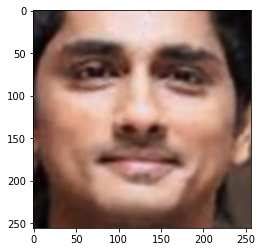

In [ ]:
i, image = next(enumerate(utk_batch))
in_img_tens = image['image']
in_msk_tens = image['mask']
in_applied_imgs = (in_img_tens * (in_msk_tens/255))

o_outputs = model(in_applied_imgs, in_msk_tens)

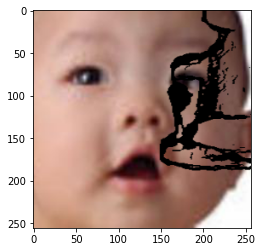

In [ ]:
imshow(tensor2image(in_applied_imgs[0]))

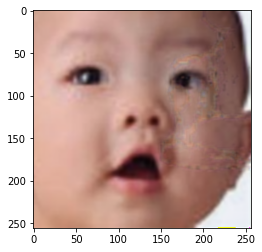

In [ ]:
imshow(tensor2image(o_outputs.detach()[0]))